# Autoencoders

В этом ноутбуке мы будем тренировать автоэнкодеры кодировать лица людей. Для этого возьмем следующий датасет: "Labeled Faces in the Wild" (LFW) (http://vis-www.cs.umass.edu/lfw/). Код для скачивания и загрузки датасета написан за вас в файле get_dataset.py


# Vanilla Autoencoder (3 балла)

## Download the data

In [1]:
# mount drive
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
import numpy as np
import os
from imageio import imread
from PIL import Image
import pandas as pd

In [0]:
# set parameters
attrs_name = "lfw_attributes.txt"
images_name = "lfw-deepfunneled"
dx = 80; dy = 80
dimx = 45; dimy = 45

In [0]:
# download
#!wget "http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz" -O /content/gdrive/My\ Drive/tmp.tgz
# print("extracting...")
# !tar xvzf /content/gdrive/My\ Drive/tmp.tgz -C /content/gdrive/My\ Drive/Autoencoders_project && rm /content/gdrive/My\ Drive/tmp.tgz
# print("done")
!ln -sf /content/gdrive/My\ Drive/Autoencoders_project/lfw-deepfunneled lfw-deepfunneled

In [0]:
# download attrs
# !wget "http://www.cs.columbia.edu/CAVE/databases/pubfig/download/""$attrs_name" -O /content/gdrive/My\ Drive/Autoencoders_project/$attrs_name
# print("done")
!ln -sf /content/gdrive/My\ Drive/Autoencoders_project/$attrs_name $attrs_name

In [0]:
# read attrs
df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,) 
df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])
#print(df_attrs.columns)
#print(df_attrs)

In [0]:
# read photos
photo_ids = []
for dirpath, dirnames, filenames in os.walk(images_name):
    for fname in filenames:
        if fname.endswith(".jpg"):
            fpath = os.path.join(dirpath,fname)
            photo_id = fname[:-4].replace('_',' ').split()
            person_id = ' '.join(photo_id[:-1])
            photo_number = int(photo_id[-1])
            photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

photo_ids = pd.DataFrame(photo_ids)
# print(photo_ids.columns)
# print(photo_ids)

# mass-merge
# (photos now have same order as attributes)
df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

assert len(df)==len(df_attrs),"lost some data when merging dataframes"

# print(df.shape)

In [0]:
# image preprocessing
all_photos =df['photo_path'].apply(imread)\
                            .apply(lambda img:img[dy:-dy,dx:-dx])\
                            .apply(lambda img: np.array(Image.fromarray(img).resize([dimx,dimy])) )

all_photos = np.stack(all_photos.values).astype('uint8')
all_attrs = df.drop(["photo_path", "person", "imagenum"], axis=1)

In [0]:
all_photos

NameError: ignored

## Prepare the data


In [0]:
import numpy as np
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
#from get_dataset import fetch_dataset
#data, attrs = fetch_dataset()
data, attrs = all_photos, all_attrs

In [0]:
IMAGE_H = data.shape[1]
IMAGE_W = data.shape[2]
# у нас цветные изображения
N_CHANNELS = 3

TRAIN_SIZE = 10000
VAL_SIZE = data.shape[0] - TRAIN_SIZE

SEED = 42
# работаем на видеокарте
DEVICE = torch.device("cuda")
EPOCHS = 10

NameError: ignored

In [0]:
import random

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True



Разбейте выборку картинок на train и val и приведите значения элементов в интервал [0, 1] типа float

In [0]:
indices = np.random.permutation(data.shape[0])
training_idx, test_idx = indices[:TRAIN_SIZE], indices[TRAIN_SIZE:]

X_train = np.array(data[:TRAIN_SIZE,:] / 255, dtype='float32')
X_val = np.array(data[TRAIN_SIZE:,:] / 255, dtype='float32')

Напишем вспомогательную функцию, которая будет выводить n_row $\cdot$ n_col первых картинок в массиве images:

In [0]:
def plot_gallery(images, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        try:
            plt.imshow(images[i].reshape((h, w, 3)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
            plt.xticks(())
            plt.yticks(())
        except:
            pass

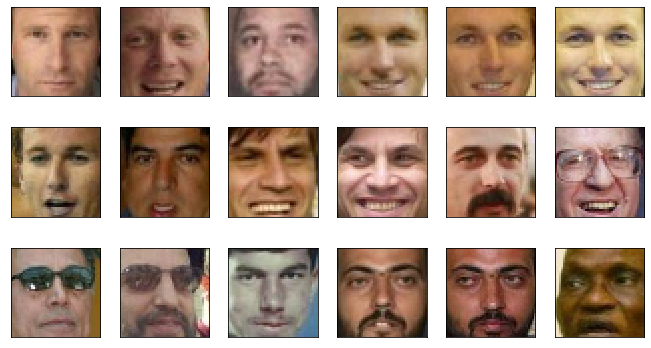

In [0]:
plot_gallery(X_train, IMAGE_H, IMAGE_W)

Осталось привести картинки к тензорам из PyTorch, чтобы можно было потом скармливать их автоэнкодеру: 

In [0]:
X_train = torch.from_numpy(X_train)
X_val = torch.from_numpy(X_val)

In [0]:
# send to GPU 
my_img_tensor.to(device)

## Autoencoder

Why to use all this complicated formulaes and regularizations, what is the need for variational inference? To analyze the difference, let's first train just an autoencoder on the data:
<img src="https://i.imgur.com/nVJAtMT.png" alt="Autoencoder">

In [0]:
inp_size=X_train.shape[1]
# размерность промежуточных слоев 
hid_size=250
# размерность среднего слоя - latent dimension
dimZ = 100

NameError: ignored

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [0]:
from copy import deepcopy

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        # define encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 8x21x21
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 16x9x9
            nn.Linear(16 * 9 * 9, 512),
            nn.ReLU(),
            nn.Linear(512, dimZ))
        
        # define encoder
        self.decoder = nn.Sequential(             
            nn.Linear(dimZ, 512),
            nn.ReLU(),
            nn.Linear(512, 16 * 9 * 9),
            nn.MaxUnpool2d(kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=3),
            nn.MaxUnpool2d(kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=8, out_channels=3, kernel_size=3),)
        
        
    def forward(self, x):
        # в качестве ваозвращаемых переменных -- латентное представление картинки (latent_code) 
        # и полученная реконструкция изображения (reconstruction)
        latent_code = self.encoder(x)
        reconstruction = self.decoder(latent_code)
        return reconstruction, latent_code

In [0]:
autoencoder = Autoencoder().to(DEVICE)
print(autoencoder)

In [0]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-4)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

Подсказка: если x_val -- каринка, а reconstruction -- ее реконструкция автоэнкодером, то красиво вывести эту каритинку и ее реконструкцию можно с помощью функции plot_gallery вот так:

*plot_gallery([x_val, reconstruction], image_h, image_w, n_row=1, n_col=2)*

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [0]:
def fit_epoch(model, train_data, criterion, optimizer):
    running_loss = 0.0
    processed_data = 0
  
    for inputs in train_data:
        inputs = inputs.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        processed_data += 1
              
    train_loss = running_loss / processed_data
    return train_loss

In [0]:
def train(train_data, val_data, model, epochs):
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f}"

    for epoch in range(epochs):
        train_loss = fit_epoch(model, train_data, criterion, optimizer)
        print("loss", train_loss)
        
        val_loss = eval_epoch(model, val_data, criterion)
        history.append((train_loss, val_loss))
            
    return history

Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

In [0]:
< тут Ваш код: выведите первые Х картинок и их реконструкций из val выборки на экран>

Not bad, right? 

## Sampling

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

#### If that doesn't work
Если вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как np.random.randn(25, <latent_space_dim>). А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как лаьентные векторы реальных фоток. Так что ридется рандом подогнать.

In [0]:
# сгенерируем 25 рандомных векторов размера latent_space
z = np.random.randn(25, <latent_space_dim>)
output = <скормите z декодеру>
plot_gallery(output.data.cpu().numpy(), IMAGE_H, IMAGE_W, n_row=5, n_col=5)

## Congrats!

Time to make fun!

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear">

План такой:

1) Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15 сойдет) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2) Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3) Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

3) А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного чувака и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [0]:
<а вот тут все это надо запрогать, да>

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии)

# Conditional Autoencoder (3 балла)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер. 
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица). 
И вот мне понадобилось сгенерировать цифру 8. И я подставляю разные варианты шума, и все никак не генерится восьмерка -- у меня получаются то пятерки, то тройки, то четверки. Гадость(

  Хотелось бы добавить к нашему AE функцию "выдай мне пожалуйста рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).
  Типа я такая говорю "выдай мне случайную восьмерку" и оно генерит случайную восьмерку!

Conditional AE -- так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части проекта мы научимся такие обучать.

## Архитектура

На картинке ниже представлена архитектура простого Conditional AE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки. 

То есть, в первый (входной) слой энкодера есть конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). Первый слой декодера есть конкатенация латентного вектора и информации о классе.


![alt text](https://i.ibb.co/2tsWknB/Screen-Shot-2020-01-15-at-9-02-15-PM.png)



Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

### P.S.
Можно ередавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

### Датасет

Как вы уже догадались, здесь мы будем использовать датасет MNIST (http://yann.lecun.com/exdb/mnist/)

Если он вам очень не нравится, можете загуглить любой другой, в котором будет четкое разделение картинок по классам.

In [0]:
<тут надо обработать датасет, построить и обучить Conditional AE (код обычного AE прекрасно берется за основу)>

## Sampling


In [0]:
<тут нужно научиться сэмплировать из декодера цифры определенного класса>

Splendid! Вы великолепны!

Теперь давайте сделаем следующее: посмотрим на то, как выглядит латентное пространство векторов, соответствующих нашим картинкам. 
Для этого вам нужно:
1.  прогнать картинки из датасета через encoder, получить латентные векторы
2. Прогнать векторы через TSNE, получить их двумерную проекцию
3. Изобразить полученные после TSNE двумерные векторы на плоскости с помощью plt.scatter, покрасив точки в цвета в зависимости от класса картинки, которой она соответствует. (как красить точки, см. в документации к plt.scatter). 
4. Подумать, что вы видите и записать свои мысли

In [0]:
<тут код получения латентных векторов, прогона через TSNE и рисования scatter plot>

<тут ваши мысли по поводу того, что вы видите на рисунке>

# BONUS 1. (2 балла) 
### Variational Autoencoder

Если вы (надеюсь) осознали, в каком месте у conditional AE выше могли бы быть проблемы, то -- тадам!!

Представляю вам проапгрейдженную версию автоэнкодеров -- вариационные автоэнкодеры.

https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf

In [0]:
class VAE(nn.Module):
    def __init__(self):
        <определите архитектуры encoder и decoder
        помните, у encoder должны быть два "хвоста", 
        т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma>

    def encode(self, x):
        <реализуйте forward проход энкодера
        в качестве ваозвращаемых переменных -- mu и logsigma>
        
        return mu, logsigma
    
    def gaussian_sampler(self, mu, logsigma):
        """
        Функция сэмплирует латентные векторы из нормального распределения с параметрами mu и sigma
        """
        if self.training:
            std = logsigma.exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu
    
    def decode(self, z):
        <реализуйте forward проход декодера
        в качестве ваозвращаемой переменной -- reconstruction>
        
        return reconstruction

    def forward(self, x):
        <используя encode и decode, реализуйте forward проход автоэнкодера
        в качестве ваозвращаемых переменных -- mu, logsigma и reconstruction>
        return mu, logsigma, mu_z, reconstruction

Определим лосс и его компоненты для VAE:

In [0]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    return -(1/2) * (1 + 2*logsigma - mu**2 - torch.exp(logsigma)**2).sum(dim=-1)

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = nn.BCELoss()
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return -(-KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)).mean()

И обучим модель:

In [0]:
criterion = <MSE LOSS>

autoencoder = Autoencoder()

optimizer = <Ваш любимый оптимизатор>

In [0]:
<обучите модель, как и autoencoder>

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

In [0]:
< тут Ваш код: выведите первые Х картинок и их реконструкций из val выборки на экран>

And finally sample from VAE.

## Sampling

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие лица получатся:

In [0]:
# вспомните про замечание из этого же ункта обычного AE про распределение латентных переменных
z = np.array([np.random.normal(0, 1, 100) for i in range(10)])
output = <скормите z декодеру>
plot_gallery(output.data.cpu().numpy(), IMAGE_H, IMAGE_W, n_row=2, n_col=5)

## Congrats v2.0!

Как вы уже догадались, здесь тоже можно попробовать пририсовывать разные атрибуты людям. Можно, например, так же пририсовать улыбки и сравнить с тем, как это получалось у обычного автоэнкодера

In [0]:
<как вы уже догадались, тут Ваш код>

# BONUS 2. (2 балла)

А теперь пришло время сделать 
## Conditional Variational AE

In [0]:
<тут обучение Conditional Variational AE>

... и так же посмотреть на латентное пространство векторов VAE, как мы делали это с обычным variational AE, понять, чем же оно отличается и сделать выводы:

In [0]:
<тут код>

<тут выводы>

# BONUS 3. (2 балла)

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения. Про одно из них это бонксное задание.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума. 
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

Для того, чтобы поставить эксперимент, нужно взять ваш любимый датасет (датасет лиц или MSE с прошлых заданий или любой другой) и сделать копию этого датасета с шумом. 

В питоне шум можно добавить так:

In [0]:
noise_factor = 0.5
X_noisy = X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X.shape) 

In [0]:
<тут ваш код обучения автоэнкодера на зашумленных картинках. Не забудтье разбить на train/test!>

In [0]:
<тут проверка, как AE убирает щум с тестовых картинок. Надеюсь, все получилось =)>

# Bonus 4. (2+ балла)

Пишем телеграм-бота!

Можно написать телеграм-бота, которому на вход вы подаете, например, картинку без улыбки, а он вам возвращает с улыбкой.

Или еще много вариантов, чего может уметь делать бот. Придумайте сами)

# Эпилог

здесь мы рассмотрели не все применения автоэнкодеров. Еще есть, например:

-- поиск аномалий
-- дополнение отсутствующих частей картины
-- работа с sequential данными (например, временными рядами)
-- гибриды ГАН+АЕ, которые активно изучаются в последнее время
-- использование латентных переменных АЕ в качестве фичей
...

Они не были частью этого проекта, потому что для их реализации пришлось бы больше возиться с датасетами. 

Но! Если вы хотите, вы, конечно, всегда можете реализовать еще что-то и получить за это еще допбаллы.

Надеюсь, вам понравилось!